In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from transformers import BertModel, BertConfig
import numpy as np
class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()

    def forward(self, inputs):
        return inputs * inputs.sigmoid()
class DepthwiseConv1D(nn.Module):
    def __init__(self, in_channels, kernel_size):
        super(DepthwiseConv1D, self).__init__()
        self.pointwise = nn.Conv1d(in_channels, in_channels, 1)
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size,padding=kernel_size//2, groups=in_channels)
        self.act2 = Swish()
        self.bn1 = nn.BatchNorm1d(in_channels)  # Batch Normalization layer
        self.bn2 = nn.BatchNorm1d(in_channels)  # Batch Normalization layer
    def forward(self, x):
        skip = x
        out = self.pointwise(x)
        out = self.bn2(out)
        out = self.depthwise(out)
        out = self.bn1(out)
        self.act2 = Swish()
        return out

class ECABlock(nn.Module):
    def __init__(self, channels, gamma=2, b=1):
        super(ECABlock, self).__init__()
        t = int(abs((math.log2(channels) + b) / gamma))
        k = t if t % 2 else t + 1
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.conv = nn.Conv1d(channels, channels, kernel_size=k, padding=k // 2, groups=channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y)
        y = self.sigmoid(y)
        return x * y.expand_as(x)

class DepthwiseConv1DECA(nn.Module):
    def __init__(self, in_channels, kernel_size):
        super(DepthwiseConv1DECA, self).__init__()
        self.depthwise_conv = DepthwiseConv1D(in_channels, kernel_size)
        self.eca = ECABlock(in_channels)

    def forward(self, x):
        out = self.depthwise_conv(x)
        out = self.eca(out)
        return out

class DepthwiseConv1DModel(nn.Module):
    def __init__(self, in_channels, kernel_size,dropout_prob=0.1):
        #embedding
        super(DepthwiseConv1DModel, self).__init__()
        # self.embedding = nn.Linear(in_channels, in_channels)
        self.conv1 = DepthwiseConv1DECA(in_channels=in_channels, kernel_size=kernel_size)
        self.dense = nn.Linear(in_channels, in_channels)
        self.dropout = nn.Dropout(dropout_prob)
        # droput
        #skip
        self.in_channels = in_channels

    def forward(self, x, mask = True): # B,L,F
        # x = self.embedding(x)
        x = x.permute(0,2,1) # B,F,L
        skip = x
        x = self.conv1(x)
        x = self.dense(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.dropout(x)
        if mask is not None :
            mask = skip != 0 
            x = x * mask
        x = x + skip/2
        return x.permute(0,2,1) # B,L,F

def positional_encoding(length, embed_dim):
    dim = embed_dim//2
    position = np.arange(length)[:, np.newaxis]     # (seq, 1)
    dim = np.arange(dim)[np.newaxis, :]/dim   # (1, dim)
    angle = 1 / (1000**dim)         # (1, dim)
    angle = position * angle    # (pos, dim)
    pos_embed = np.concatenate(
        [np.sin(angle), np.cos(angle)],
        axis=-1
    )
    pos_embed = torch.from_numpy(pos_embed).float()
    return pos_embed


class XEmbed(nn.Module):
    def __init__(self, embed_dim
    ):
        super().__init__()
        self.v = nn.Sequential(
            nn.Linear(390, embed_dim*2, bias=True),
            nn.LayerNorm(embed_dim*2),
            nn.ReLU(inplace=True),
            nn.Linear(embed_dim*2, embed_dim, bias=True),
            nn.LayerNorm(embed_dim),
            nn.ReLU(inplace=True),
    )
    def forward(self, x, x_mask):
        B,L,_ = x.shape
        v = self.v(x)
        x = v
        return x, x_mask

class TransformerBlock(nn.Module):
    def __init__(self,
        embed_dim,
        num_head,
        out_dim,
    ):
        super().__init__()
        self.attn  = MyMultiHeadAttention(
            embed_dim=embed_dim,
            out_dim=embed_dim,
            qk_dim=embed_dim // num_head,
            v_dim=embed_dim // num_head,
            num_head=num_head,
        )
        self.ffn   = FeedForward(embed_dim, out_dim*2)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(out_dim)

    def forward(self, x, x_mask=None):
        x = x + F.dropout(self.attn((self.norm1(x)), x_mask), 0.1)
        x = x + F.dropout(self.ffn((self.norm2(x))), 0.1)
        return x

class MyMultiHeadAttention(nn.Module):
    def __init__(self,
            embed_dim,
            out_dim,
            qk_dim,
            v_dim,
            num_head,
        ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_head  = num_head
        self.qk_dim = qk_dim
        self.v_dim  = v_dim

        self.q = nn.Linear(embed_dim, qk_dim*num_head)
        self.k = nn.Linear(embed_dim, qk_dim*num_head)
        self.v = nn.Linear(embed_dim, v_dim*num_head)

        self.out = nn.Linear(v_dim*num_head, out_dim)
        self.scale = 1/(qk_dim**0.5)

    #https://github.com/pytorch/pytorch/issues/40497
    def forward(self, x, x_mask):
        B,L,dim = x.shape
        #out, _ = self.mha(x,x,x, key_padding_mask=x_mask)
        num_head = self.num_head
        qk_dim = self.qk_dim
        v_dim = self.v_dim

        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        q = q.reshape(B, L, num_head, qk_dim).permute(0,2,1,3).contiguous()
        k = k.reshape(B, L, num_head, qk_dim).permute(0,2,3,1).contiguous()
        v = v.reshape(B, L, num_head, v_dim ).permute(0,2,1,3).contiguous()

        dot = torch.matmul(q, k) *self.scale  # H L L
        x_mask = x_mask.reshape(B,1,1,L).expand(-1,num_head,L,-1)
        #dot[x_mask]= -1e4
        dot.masked_fill_(x_mask, -1e4)
        attn = F.softmax(dot, -1)    # L L

        v = torch.matmul(attn, v)  # L H dim
        v = v.permute(0,2,1,3).reshape(B,L, v_dim*num_head).contiguous()
        out = self.out(v)

        return out

class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, embed_dim),
        )
    def forward(self, x):
        return self.mlp(x)

class M(nn.Module):

    def __init__(self, num_block, num_class, num_landmark, max_length, embed_dim, num_head, in_channels, kernel_size):
        super().__init__()
        self.depcov1 = DepthwiseConv1DModel(in_channels, kernel_size)
        self.depcov2 = DepthwiseConv1DModel(in_channels, kernel_size)
        self.x_embed = XEmbed(embed_dim)
        pos_embed = positional_encoding(max_length, embed_dim)
        self.pos_embed = nn.Parameter(pos_embed) 
        self.cls_embed = nn.Parameter(torch.zeros((1, embed_dim)))

        self.encoder = nn.ModuleList([
            TransformerBlock(
                embed_dim,
                num_head,
                embed_dim,
            ) for i in range(num_block)
        ])
        self.logit = nn.Linear(embed_dim, num_class)

    def forward(self, x, dropout=None):
        x = self.depcov1(x)
        x = self.depcov2(x)
        x_mask = x.max(dim=2)[0].ne(0).long()

        x, x_mask = self.x_embed(x, x_mask)
        B,L,_ = x.shape
        if self.training:
            # randomly mask each element of the input sequence with probability 0.15
            B,L,_ = x.shape
            prob_mask = torch.empty(x_mask.shape[0], x_mask.shape[1]).uniform_(0, 1).to(device=x_mask.device)
            prob_mask = (prob_mask > 0.15).long()
            x_mask = x_mask * prob_mask
        x_mask = (x_mask<0.5)

        x = x + self.pos_embed[:L].unsqueeze(0)
        x = torch.cat([
            self.cls_embed.unsqueeze(0).repeat(B,1,1),
            x
        ],1)
        x_mask = torch.cat([
            torch.zeros(B,1).to(x_mask),
            x_mask
        ],1)
 
        for block in self.encoder:
            x = block(x,x_mask)

        if dropout:
            x = F.dropout(x,p=dropout)

        x_mask = x_mask.unsqueeze(-1)
        x_mask = 1-x_mask.float()
        last = (x*x_mask).sum(1)/x_mask.sum(1)
        logit = self.logit(last)
        return logit
# num_class  = 50
# num_landmark = 390
# max_length = 124
# embed_dim  = 480
# num_head   = 16
model = M(num_block=3, num_class=50, num_landmark=390, max_length=124, embed_dim=512, num_head=16,in_channels=390,kernel_size=17)
input_data = torch.randn(16, 124, 390)
# for name, layer in model.named_children():
#   if name == 'logit':
#     new_fc2 = nn.Linear(in_features=layer.in_features, out_features=50, bias=layer.bias is not None)
#     setattr(model, name, new_fc2)
#     break
for name, layer in model.named_children():
  if name == 'logit':
    print(name)
    print(layer)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
model(input_data).shape# b , l , lanmark

logit
Linear(in_features=512, out_features=50, bias=True)
Total parameters: 7957278


torch.Size([16, 50])

In [ ]:
checkpoint = torch.load('output/weights/cfg_3/_22/checkpoint_best_seed-1.pth', map_location=torch.device('cpu'))
model_state_dict = checkpoint['model']
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for inputs, labels in data_loader:
            inputs, labels  = inputs.to(cfg.device), labels.to(cfg.device)
            output = model(inputs)
            # loss = criterion(inputs, labels)
            # val_loss += loss.item()
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += inputs.shape[0]
        model.train()
        # average_loss = val_loss / len(dataloader)
    return correct / total

def topKaccuracy(model, data_loader, topk=(1,)):
    device = next(model.parameters()).device
    with torch.no_grad():
        total = 0
        corrects = {k: 0 for k in topk}
        
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.topk(outputs, max(topk), dim=1)
            total += labels.size(0)
            
            for k in topk:
                corrects[k] += torch.sum(torch.any(predicted[:, :k] == labels.view(-1, 1), dim=1)).item()

        accuracies = [(corrects[k] / total)  for k in topk] 
    
    return accuracies

accuracies_iter = []
for epoch in range(30):
    topk = topKaccuracy(model, val_dataloader, topk=(1,3,5))
    accuracies_iter.append(topk)

In [ ]:
accuracies_iter

cpu
Total parameters: 7957278


c:\Users\Admin\anaconda3\Lib\site-packages\torch\cuda\amp\grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


All save in:  output/weights/cfg_3_1/


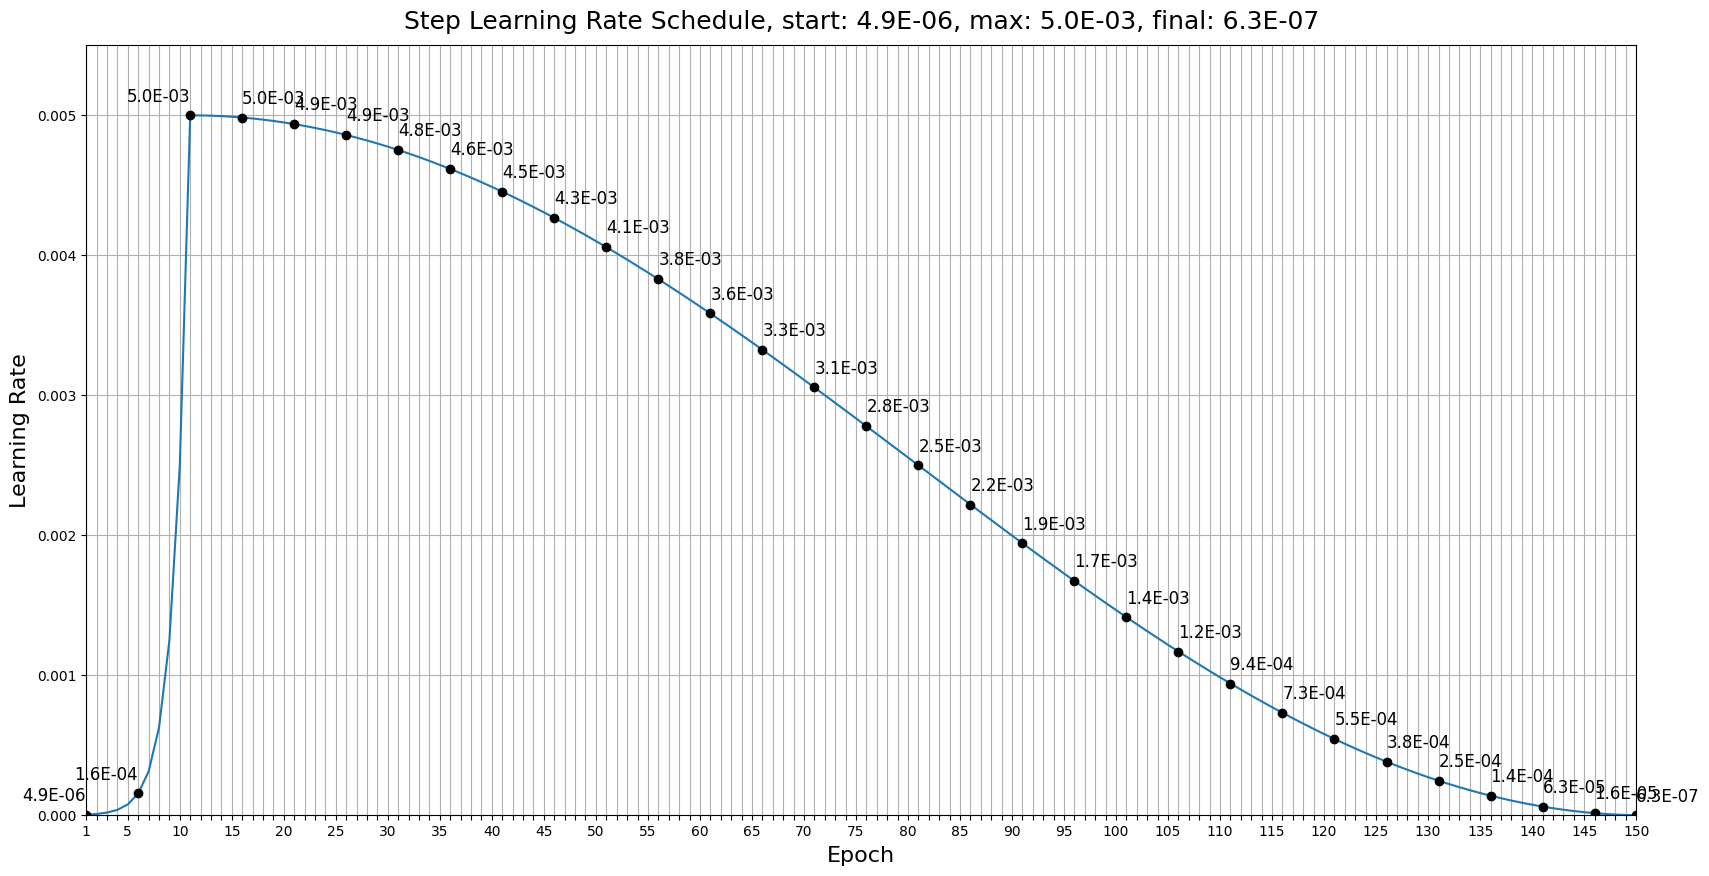

Epoch 1/150:   0%|          | 0/44 [00:09<?, ?batch/s]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\Admin\anaconda3\Lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "f:\6.Spring_24\VIetNamese_sign_language\.//data\ds_1.py", line 108, in __getitem__
    data = self.load_one(file_id, sequence_id)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "f:\6.Spring_24\VIetNamese_sign_language\.//data\ds_1.py", line 143, in load_one
    data = np.load(path) # seq_len, 3* nlandmarks
           ^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\npyio.py", line 427, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'dataset/train_landmarks_npy/VSL50/bame_gx_4.npy'


In [2]:
import os
import glob
import gc
from copy import copy
import numpy as np
import pandas as pd
import importlib
import sys
from tqdm import tqdm, notebook
import argparse
import torch
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader,TensorDataset
from collections import defaultdict
import transformers
# from decouple import Config, RepositoryEnv
import random
from utils import *



BASEDIR= './'#'../input/asl-fingerspelling-config'
for DIRNAME in 'configs data models postprocess metrics'.split():
    sys.path.append(f'{BASEDIR}/{DIRNAME}/')


parser = argparse.ArgumentParser(description="")
parser.add_argument("-C", "--config", help="config filename", default="cfg_3")
parser.add_argument("-G", "--gpu_id", default="", help="GPU ID")
parser_args, other_args = parser.parse_known_args(sys.argv)
cfg = copy(importlib.import_module(parser_args.config).cfg)

CustomDataset = importlib.import_module(cfg.dataset).CustomDataset
Net = importlib.import_module(cfg.model).Net



cfg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(cfg.device)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection  import train_test_split
train_df = pd.read_csv('./dataset/train.csv')
val_df = pd.read_csv('./dataset/test.csv')
# Sử dụng LabelEncoder để chuyển đổi cột 'phrase' thành số
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['phrase'])
val_df['label'] = label_encoder.fit_transform(val_df['phrase'])
# Tách dữ liệu ra thành tập huấn luyện và tập kiểm thử

# Set up the dataset and dataloader
train_dataset = CustomDataset(train_df, cfg, aug=cfg.train_aug, mode="train")
val_dataset = CustomDataset(val_df, cfg, aug=cfg.train_aug, mode="val")

train_dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        batch_size=cfg.batch_size,
        num_workers=2,
        pin_memory= True
    )
val_dataloader = DataLoader(
        val_dataset,
        batch_size=cfg.batch_size,
        num_workers=2,
        pin_memory= True
    )



model = Net(num_block=cfg.num_block,
        num_class=cfg.num_class,
        num_landmark=cfg.num_landmark,
        max_length=cfg.max_length,
        embed_dim=cfg.embed_dim,
        num_head=cfg.num_head, 
        in_channels=cfg.in_channels, 
        kernel_size=cfg.kernel_size).to(cfg.device)

# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr_max, weight_decay=cfg.weight_decay)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()


# Start the training and validation loop
cfg.curr_step = 0
optimizer.zero_grad()
total_grad_norm = None    
total_grad_norm_after_clip = None
i = 0 

index = 1
while os.path.exists(new_path := f"{cfg.path}_{index}/"):
    index += 1
os.makedirs(new_path)
path = new_path
print("All save in: ",path)

LR_SCHEDULE = [lrfn(step, num_warmup_steps=cfg.nwarmup, lr_max=cfg.lr_max,num_training_steps=cfg.epochs, num_cycles=cfg.num_cycles) for step in range(cfg.epochs)]
plot_lr_schedule(LR_SCHEDULE, cfg.epochs)
iters  = []
losses = []
topk_accuracy = []
#   val_acc_list = []q
learning_rates=[]
n = 0

for epoch in range(cfg.epochs):
    if cfg.warmup_status == True:
        for param_group in optimizer.param_groups:
            param_group['lr'] = LR_SCHEDULE[epoch]
    learning_rates.append(optimizer.param_groups[0]['lr'])
    for inputs, labels in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{cfg.epochs}', unit='batch'):
        inputs, labels = inputs.to(cfg.device), labels.to(cfg.device)
        model.train()
        out = model(inputs)

        loss = criterion(out, labels.long()) # compute the total loss
        loss.backward()
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # a clean up step for PyTorch
        iters.append(n)
        losses.append(float(loss)/cfg.batch_size) # compute *average* loss

        with torch.no_grad():
            total = 0
            corrects = {k: 0 for k in cfg.topk}
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(cfg.device), labels.to(cfg.device)
                outputs = model(inputs)
                _, predicted = torch.cfg.topk(outputs, max(int(x) for x in cfg.topk), dim=1)
                total += labels.size(0)
                for k in cfg.topk:
                    corrects[k] += torch.sum(torch.any(predicted[:, :int(k)] == labels.view(-1, 1), dim=1)).item()
            accuracies = [(corrects[k] / total)  for k in cfg.topk]
        topk_accuracy.append(accuracies)
        if topk_accuracy[n][0] > best_accuracy :
          best_accuracy = topk_accuracy[n][0]
          best_model = model
          torch.save({"model": best_model.state_dict()},path+f"checkpoint_best_seed{cfg.seed}.pth")
        n += 1
    print(" ".join([f"top{k}_accuracy: {round(topk_accuracy[n-1][i],4)} -  " for i, k in enumerate(topk)])+f'train_loss: {round(losses[-1],3)} -  learning_rate: {round(learning_rates[-1],7)}\n ')
    print("The best accuracy is: ", best_accuracy)

draw_plot(cfg.epochs,learning_rates,cfg.batch_size,iters,topk, topk_accuracy,losses,path)
torch.save({"model": model.state_dict()},path+f"checkpoint_last_seed{cfg.seed}.pth")
print(f"Checkpoint save : " +  path+f"checkpoint_last_seed{cfg.seed}.pth")

In [ ]:
# Example of usage:
import torch
output = torch.randn(10, 5)  # Example output tensor (batch_size=10, num_classes=5)
target = torch.randint(0, 5, (10,))  # Example target tensor
target

tensor([2, 2, 2, 1, 0, 0, 0, 4, 0, 4])

In [6]:
cfg.dataset

'ds_1'

In [1]:
import pandas as pd
df = pd.read_parquet('./dataset/train_landmark_files/VSL50.parquet')
df

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
buontham_gg_1,0,0.507045,0.506541,0.506740,0.500568,0.506178,0.505721,0.504571,0.463570,0.503743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buontham_gg_1,1,0.506245,0.504391,0.505141,0.498340,0.503934,0.503435,0.502385,0.461943,0.501607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buontham_gg_1,2,0.504886,0.503322,0.503986,0.497264,0.502828,0.502325,0.501242,0.461096,0.500315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buontham_gg_1,3,0.504880,0.502842,0.503582,0.496367,0.502243,0.501559,0.500039,0.460069,0.498889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buontham_gg_1,4,0.505297,0.503502,0.504177,0.496918,0.502888,0.502163,0.500476,0.460454,0.499262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dia_chi-mien_nam,128,0.495297,0.495678,0.495478,0.493281,0.495808,0.495943,0.496206,0.472776,0.496506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dia_chi-mien_nam,129,0.495417,0.495810,0.495611,0.493402,0.495937,0.496068,0.496314,0.472942,0.496601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dia_chi-mien_nam,130,0.495606,0.495993,0.495779,0.493583,0.496126,0.496253,0.496490,0.473076,0.496793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
pd.read_csv('./dataset/train.csv')

,Unnamed: 0,path,file_id,sequence_id,phrase
0,1531,./dataset/train_landmark_files/VSL50.parquet,VSL50,diachi_gg_3,địa chỉ
1,559,./dataset/train_landmark_files/VSL50.parquet,VSL50,hen_tx_3,hẹn
2,1017,./dataset/train_landmark_files/VSL50.parquet,VSL50,mytom_pg_4,mỳ tôm
3,160,./dataset/train_landmark_files/VSL50.parquet,VSL50,bome_gg_5,bố mẹ
4,1253,./dataset/train_landmark_files/VSL50.parquet,VSL50,thuongxuyen_gg_5,thường xuyên
...,...,...,...,...,...
1399,324,./dataset/train_landmark_files/VSL50.parquet,VSL50,contrai_pg_1,con trai
1400,1109,./dataset/train_landmark_files/VSL50.parquet,VSL50,nongtinh_px_4,nóng tính
1401,490,./dataset/train_landmark_files/VSL50.parquet,VSL50,hangngay_tg_1,hàng ngày
1402,1146,./dataset/train_landmark_files/VSL50.parquet,VSL50,naunuong_tg_5,nấu nướng
